In [1]:
import numpy as np
import keras
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import glob

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


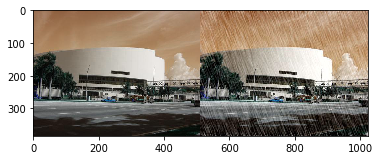

In [2]:
images = []
for i in glob.glob("*.jpg"):
    images.append(cv2.imread(i))

plt.imshow(images[0])

In [3]:
co = 0
rain_im = []
derain_im = []
for i in images:
    #print(co)
    co += 1
    col = i.shape[1]
    im = i[:,:col//2,:]
    im2 = i[:,col//2:,:]
    derain_im.append(im)
    rain_im.append(im2)

In [4]:
derain_final = []
for i in derain_im:
    x = cv2.resize(i,(256,256))
    derain_final.append(x)

In [5]:
rain_final = []
for i in rain_im:
    x = cv2.resize(i,(256,256))
    rain_final.append(x)

In [56]:
k_rain = []
batch_size = 7
for i in range(0,700,batch_size):
    ldd = []
    for j in range(i,i+batch_size):
        ldd.append(rain_final[j])
    k_rain.append(ldd)
    
print(len(k_rain))
#print(k_rain[3])
#k_rain[:] = [[[x / float(255) for x in y]for y in z]for z in k_rain]
#plt.imshow(rain_final[3])
print(len(k_rain[0]))
print(len(k_rain[0][0]))
print(len(k_rain[0][0][0]))
print(len(k_rain[0][0][0][0]))

100
7
256
256
3


In [58]:
k_derain = []
batch_size = 7
for i in range(0,700,batch_size):
    ldd = []
    for j in range(i,i+batch_size):
        ldd.append(derain_final[j])
    k_derain.append(ldd)
    
print(len(k_derain))
#k_derain[:] = [[[x / float(255) for x in y]for y in z]for z in k_derain]
#print(k_derain[1])
print(len(k_derain[0]))
print(len(k_derain[0][0]))
print(len(k_derain[0][0][0]))
print(len(k_derain[0][0][0][0]))

100
7
256
256
3


In [16]:
import tensorflow as tf

In [25]:
def model_inputs(real_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, *real_dim), name='input_z')
    
    return inputs_real, inputs_z

In [45]:
def prelu(x):
    alpha = tf.Variable(0.1,name = 'alpha')
    return tf.maximum(alpha*x,x)


In [46]:
def generator(z, reuse=False, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        #x1 = tf.placeholder(tf.float32,shape=[None,256,256,3])
        #Y = tf.placeholder(tf.float32,shape=[None,256,256,3])

        x2 = tf.layers.conv2d(z,64,3,strides=1,padding='same')
        x2 = tf.layers.batch_normalization(x2, training = training)
        x2 = prelu(x2)

        x3 = tf.layers.conv2d(x2,64,3,strides=1,padding='same')
        x3 = tf.layers.batch_normalization(x3, training = training)
        x3 = prelu(x3)

        x4 = tf.layers.conv2d(x3,64,3,strides=1,padding='same')
        x4 = tf.layers.batch_normalization(x4, training = training)
        x4 = prelu(x4)

        x5 = tf.layers.conv2d(x4,64,3,strides=1,padding='same')
        x5 = tf.layers.batch_normalization(x5, training = training)
        x5 = prelu(x5)

        x6 = tf.layers.conv2d(x5,32,3,strides=1,padding='same')
        x6 = tf.layers.batch_normalization(x6, training = training)
        x6 = prelu(x6)
    
        x7 = tf.layers.conv2d(x6,1,3,strides=1,padding='same')
        x7 = tf.layers.batch_normalization(x7, training = training)
        x7 = prelu(x7)

        x8 = tf.layers.conv2d_transpose(x7,32,3,strides=1,padding='same')
        x8 = tf.layers.batch_normalization(x8, training = training)
        x8 = tf.nn.relu(x8)

        x9 = tf.layers.conv2d_transpose(x8,64,3,strides=1,padding='same')
        x9 = tf.layers.batch_normalization(x9, training = training)
        x9 = tf.nn.relu(x9)

        x9 = x9 + x5

        x10 = tf.layers.conv2d_transpose(x9,64,3,strides=1,padding='same')
        x10 = tf.layers.batch_normalization(x10, training = training)
        x10 = tf.nn.relu(x10)

        x11 = tf.layers.conv2d_transpose(x10,64,3,strides=1,padding='same')
        x11 = tf.layers.batch_normalization(x11, training = training)
        x11 = tf.nn.relu(x11)

        x11 = x11 + x3

        x12 = tf.layers.conv2d_transpose(x11,64,3,strides=1,padding='same')
        x12 = tf.layers.batch_normalization(x12, training = training)
        x12 = tf.nn.relu(x12)

        x13 = tf.layers.conv2d_transpose(x12,3,3,strides=1,padding='same')
        x13 = tf.layers.batch_normalization(x13, training = training)
        x13 = tf.nn.relu(x13)

        logits = x13 + z

        out = tf.tanh(logits)
        return out

In [47]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        x101 = tf.layers.conv2d(x,48,4,strides=2,padding='same')
        x101 = tf.layers.batch_normalization(x101, training=True)

        x102 = tf.layers.conv2d(x101,96,4,strides=2,padding='same')
        x102 = tf.layers.batch_normalization(x102, training=True)
        x102 = prelu(x102)

        x103 = tf.layers.conv2d(x102,192,4,strides=2,padding='same')
        x103 = tf.layers.batch_normalization(x103, training=True)
        x103 = prelu(x103)

        x104 = tf.layers.conv2d(x103,384,4,strides=1,padding='same')
        x104 = tf.layers.batch_normalization(x104, training=True)
        x104 = prelu(x104)

        x105 = tf.layers.conv2d(x104,1,4,strides=1,padding='same')

        flat2 = tf.reshape(x105,(-1,32*32*1))
        logits12 = tf.layers.dense(flat2,1)
        out2 = tf.sigmoid(logits12)
        
        return out2,logits12

In [48]:
def model_loss(input_real, input_z):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

In [49]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [50]:
class GAN:
    def __init__(self, real_size, learning_rate, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [54]:
def train(net, rain, derain, epochs, batch_size, batches, print_every=1) :
    saver = tf.train.Saver()
    losses = []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for i in range(0,batches):
                
            #for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = derain[i]
                
                x = rain[i]

                # Run optimizers
                _  = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _  = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

        saver.save(sess, './checkpoints/generator.ckpt')

    return losses

In [55]:
real_size = (256,256,3)
learning_rate = 0.002
batch_size = 7
epochs = 25
beta1 = 0.5
batches = 100

In [53]:
net = GAN(real_size, learning_rate, beta1=beta1)

In [ ]:
losses = train(net, k_rain, k_derain, epochs, batch_size, batches)

Epoch 1/25... Discriminator Loss: 0.0000... Generator Loss: 29.1715
Epoch 1/25... Discriminator Loss: 0.2898... Generator Loss: 14.3659
Epoch 1/25... Discriminator Loss: 0.0015... Generator Loss: 16.1539
Epoch 1/25... Discriminator Loss: 0.0001... Generator Loss: 16.4974
Epoch 1/25... Discriminator Loss: 0.0012... Generator Loss: 13.1608
Epoch 1/25... Discriminator Loss: 0.0000... Generator Loss: 19.8482
Epoch 1/25... Discriminator Loss: 0.0006... Generator Loss: 11.0331
Epoch 1/25... Discriminator Loss: 0.0002... Generator Loss: 22.4104
Epoch 1/25... Discriminator Loss: 1.3609... Generator Loss: 22.3940
